## START HERE. Import Stuff

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

In [3]:
import torch
torch.cuda.is_available()

True

In [4]:
torch.backends.cudnn.enabled

True

# Get data

In [6]:
help(untar_data) # Using this to do download :)

Help on function untar_data in module fastai.datasets:

untar_data(url: str, fname: Union[pathlib.Path, str] = None, dest: Union[pathlib.Path, str] = None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if it doesn't exist, and un-tgz to folder `dest`.



In [7]:
doc(untar_data)

In [8]:
path = untar_data(URLs.PETS)
path

PosixPath('/home/luan/.fastai/data/oxford-iiit-pet')

In [9]:
path.ls()

[PosixPath('/home/luan/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/home/luan/.fastai/data/oxford-iiit-pet/annotations')]

In [10]:
path_anno = path/"annotations"
path_img = path/"images"

# Display samples

In [13]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/home/luan/.fastai/data/oxford-iiit-pet/images/beagle_67.jpg'),
 PosixPath('/home/luan/.fastai/data/oxford-iiit-pet/images/samoyed_14.jpg'),
 PosixPath('/home/luan/.fastai/data/oxford-iiit-pet/images/basset_hound_169.jpg'),
 PosixPath('/home/luan/.fastai/data/oxford-iiit-pet/images/miniature_pinscher_91.jpg'),
 PosixPath('/home/luan/.fastai/data/oxford-iiit-pet/images/British_Shorthair_136.jpg')]

In [14]:
np.random.seed(10)
pat = r'/([^/]+)_\d+.jpg$'

In [5]:
bs = 64

In [15]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)                            

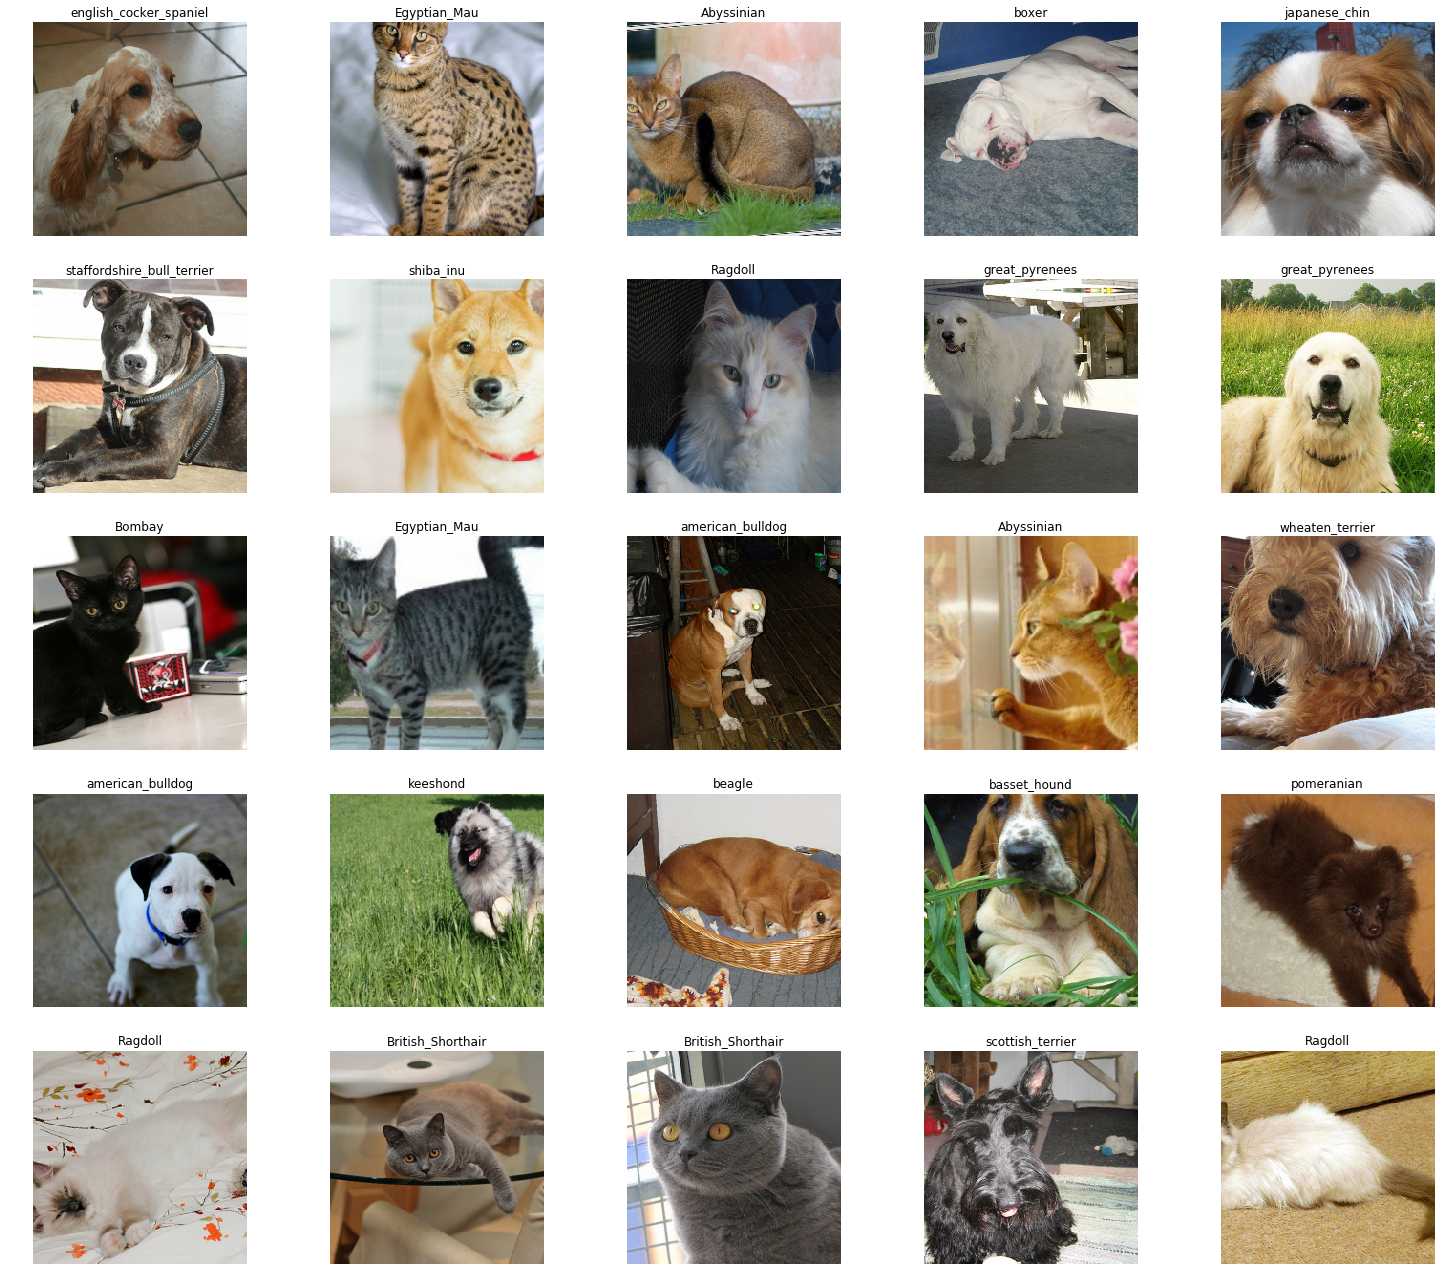

In [16]:
data.show_batch(figsize=(21,18))

In [17]:
print(data.classes)
len(data.classes), data.c

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

# Training resnet34

In [18]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [19]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [20]:
learn.fit_one_cycle(4)     # Why using fix_one_cycle ? 

In [21]:
learn.save("stage-1")

# Result of first training

In [22]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()

# Sanity check
len(data.valid_ds) == len(losses) == len(idxs)


True

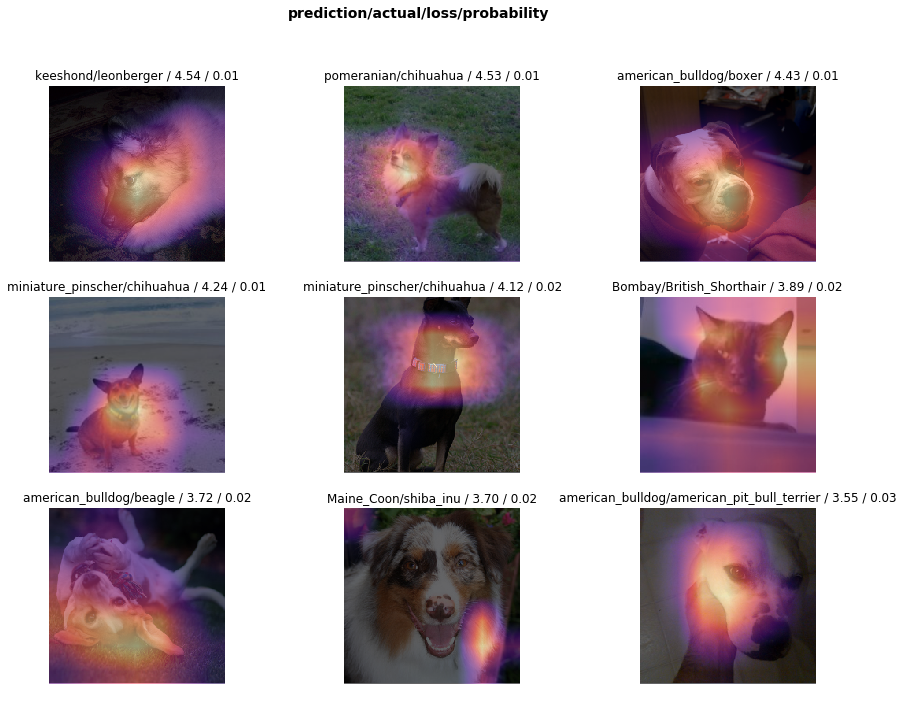

In [23]:
interp.plot_top_losses(9, figsize=(15,11))


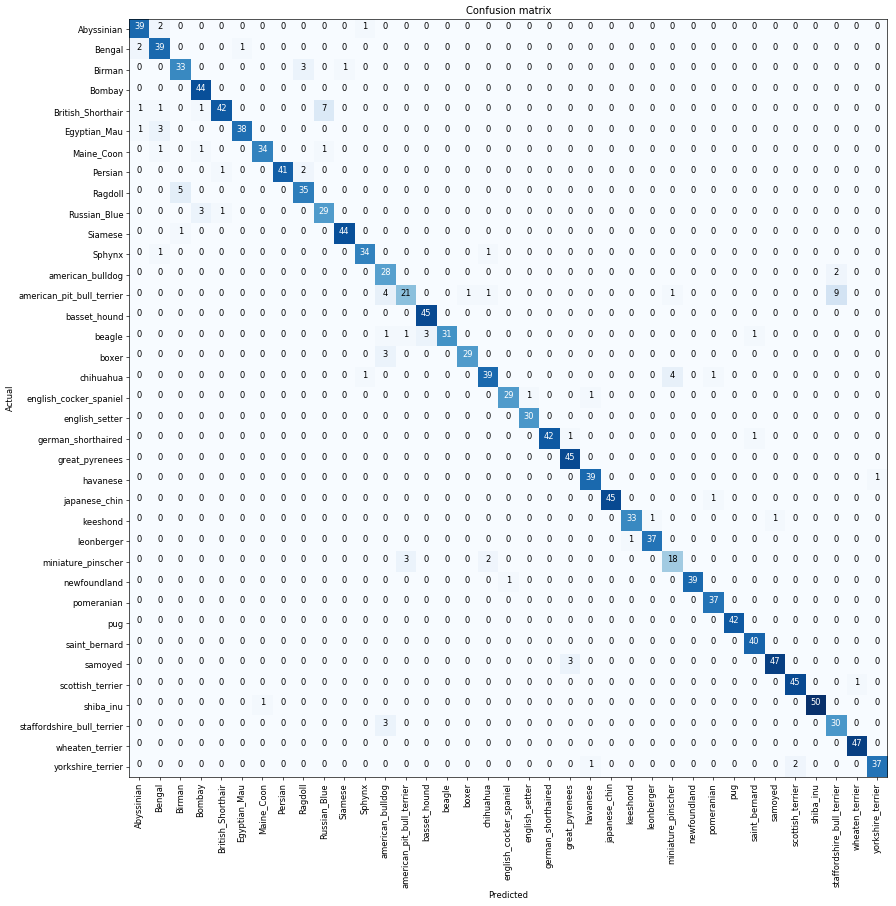

In [24]:
interp.plot_confusion_matrix(figsize=(15, 15), dpi=60)

In [25]:
interp.most_confused(min_val=2)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 9),
 ('British_Shorthair', 'Russian_Blue', 7),
 ('Ragdoll', 'Birman', 5),
 ('american_pit_bull_terrier', 'american_bulldog', 4),
 ('chihuahua', 'miniature_pinscher', 4),
 ('Birman', 'Ragdoll', 3),
 ('Egyptian_Mau', 'Bengal', 3),
 ('Russian_Blue', 'Bombay', 3),
 ('beagle', 'basset_hound', 3),
 ('boxer', 'american_bulldog', 3),
 ('miniature_pinscher', 'american_pit_bull_terrier', 3),
 ('samoyed', 'great_pyrenees', 3),
 ('staffordshire_bull_terrier', 'american_bulldog', 3)]

# Retrain the big model

In [26]:
learn.unfreeze()

In [27]:
learn.fit_one_cycle(1)

Definitely wrong here. The error rate is higher :D

In [28]:
learn.load("stage-1")

Learner(data=ImageDataBunch;

Train: LabelList (5912 items)
x: ImageItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
beagle,samoyed,basset_hound,miniature_pinscher,Bengal
Path: /home/luan/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
japanese_chin,chihuahua,great_pyrenees,leonberger,Russian_Blue
Path: /home/luan/.fastai/data/oxford-iiit-pet/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_siz

In [29]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 7.59E-07


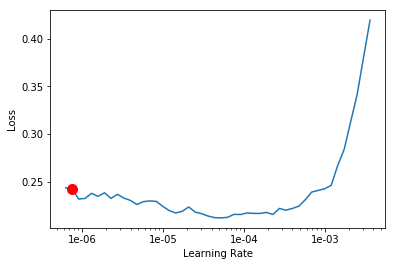

In [30]:
learn.recorder.plot()

In [31]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-06, 1e-04))

Much Better. Error rate goes down

# Now doing resnet50

In [32]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)

In [33]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-03


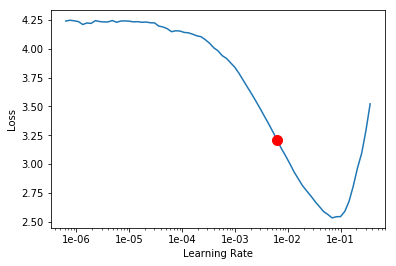

In [34]:
learn.lr_find()
learn.recorder.plot()

In [35]:
learn.freeze()

In [36]:
learn.fit_one_cycle(5,max_lr=6e-03)

In [37]:
learn.save("stage-1-50")

In [38]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-06, 1e-04))

In [39]:
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused(min_val=2)

[('Ragdoll', 'Birman', 6),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 6),
 ('chihuahua', 'miniature_pinscher', 6),
 ('Egyptian_Mau', 'Bengal', 5),
 ('Bengal', 'Egyptian_Mau', 4),
 ('Siamese', 'Birman', 4)]

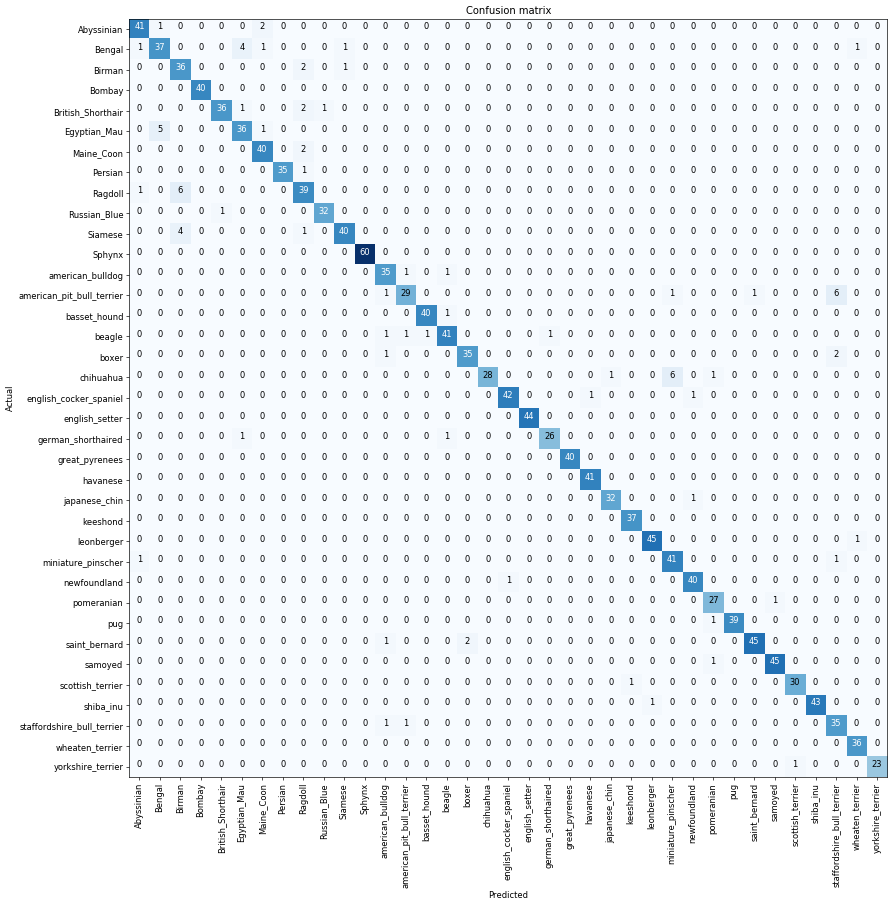

In [40]:
interp.plot_confusion_matrix(figsize=(15, 15), dpi=60)